## Main Objective: 
The task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly.


## Data Understanding
train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.  
1. PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
2. HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
3. CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
4. Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
5. Destination - The planet the passenger will be debarking to.
6. Age - The age of the passenger.
7. VIP - Whether the passenger has paid for special VIP service during the voyage.
8. RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
9. Name - The first and last names of the passenger.
10. Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [2]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("../dataset/train.csv")

#### What is the extent of missing values across each feature, and are there patterns to the missingness?
Understanding which columns have gaps and whether missingness correlates with other variables (e.g., CryoSleep passengers missing amenity data) will inform imputation strategies.

In [4]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [5]:
df.isnull().mean() * 100

PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64

> The percentages help to decide whether imputation or dropping is reasonable (e.g., 2% vs 40%). It seems we should impute the missingness!  
No single column is overwhelmingly missing, so we won’t need to drop entire features. instead, we'll want smart imputation or indicator flags.

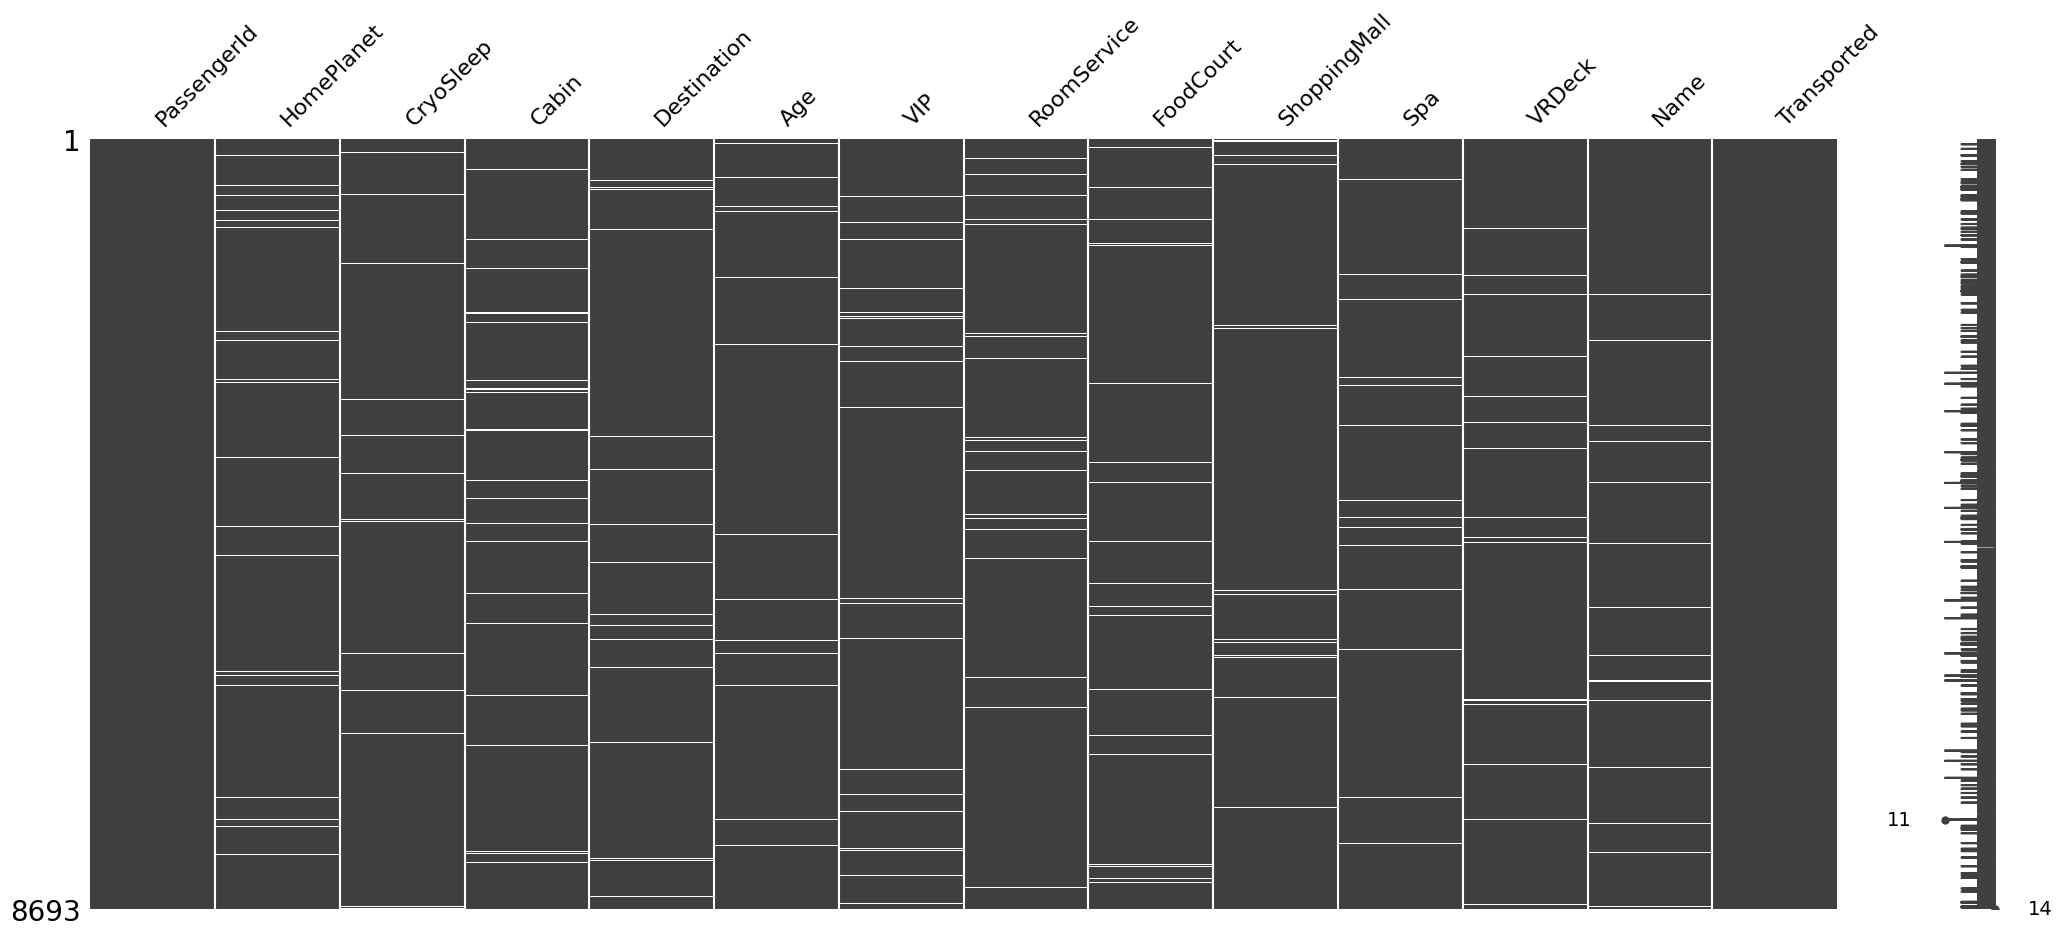

In [6]:
msno.matrix(df)
plt.show()

> If the line is white across several columns, that passenger has missing values in multiple features.   
clusters of horizontal lines close together, that means several passengers in sequence (often from the same group/family, since PassengerId encodes groups) are missing similar sets of features.   
> These patterns are important because they hint at MAR (Missing At Random) rather than MCAR.  

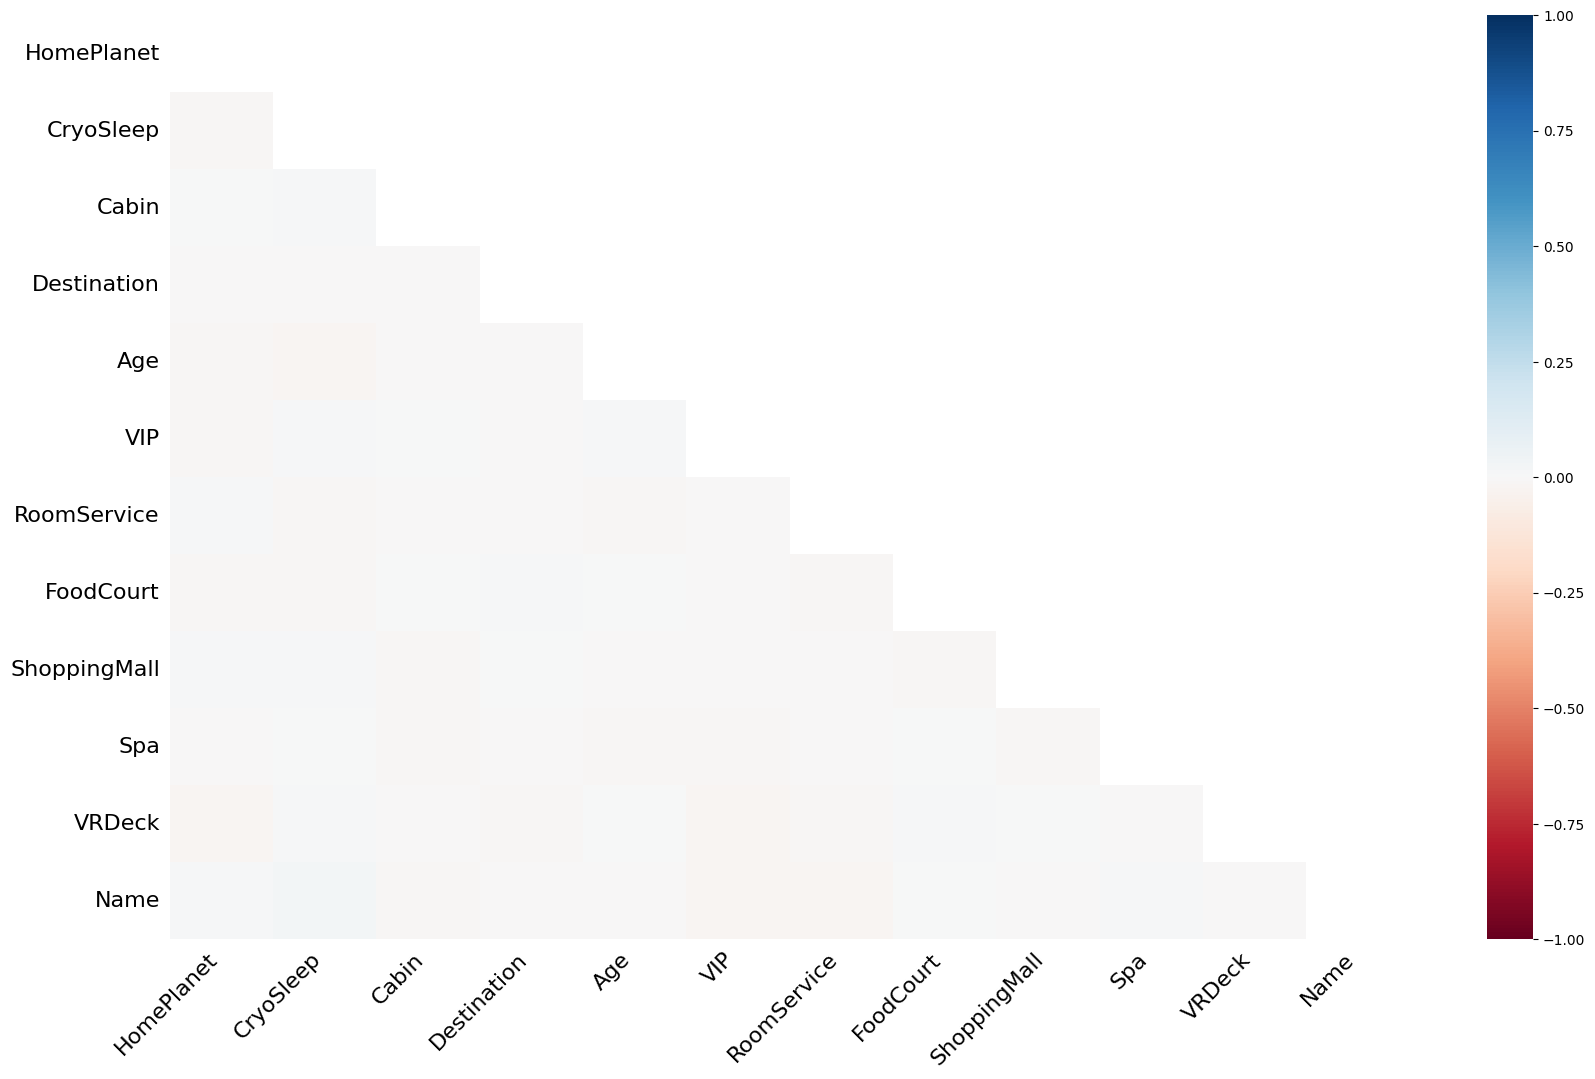

In [7]:
msno.heatmap(df)
plt.show()

It’s a correlation matrix of missingness. Each cell measures how strongly the missingness of one feature is related to another.  
1. Positive correlation (close to +1): if column A is missing, column B is also often missing.
2. Zero correlation: missingness in A and B are independent.
3. Negative correlation: if A is missing, B is usually present.

HomePlanet, CryoSleep, Cabin, Destination, Age, VIP, These features tend to have missing values together. For example, if Cabin is missing, there’s a higher chance HomePlanet or VIP is missing too. That’s why they cluster positively.  
Other features showing negatives: That means when those features are missing, the “positive cluster” features are usually present.  

1. Structured missingness exists: HomePlanet, CryoSleep, Cabin, Destination, Age, VIP often go missing together.  
2. Independent missingness: Spending features (RoomService, FoodCourt)

#### What are the distributions of numerical features (Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck), and are there outliers or skewness that need addressing?
Highly skewed spending data or outliers could affect model performance and suggest transformations.

In [8]:
num_features = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

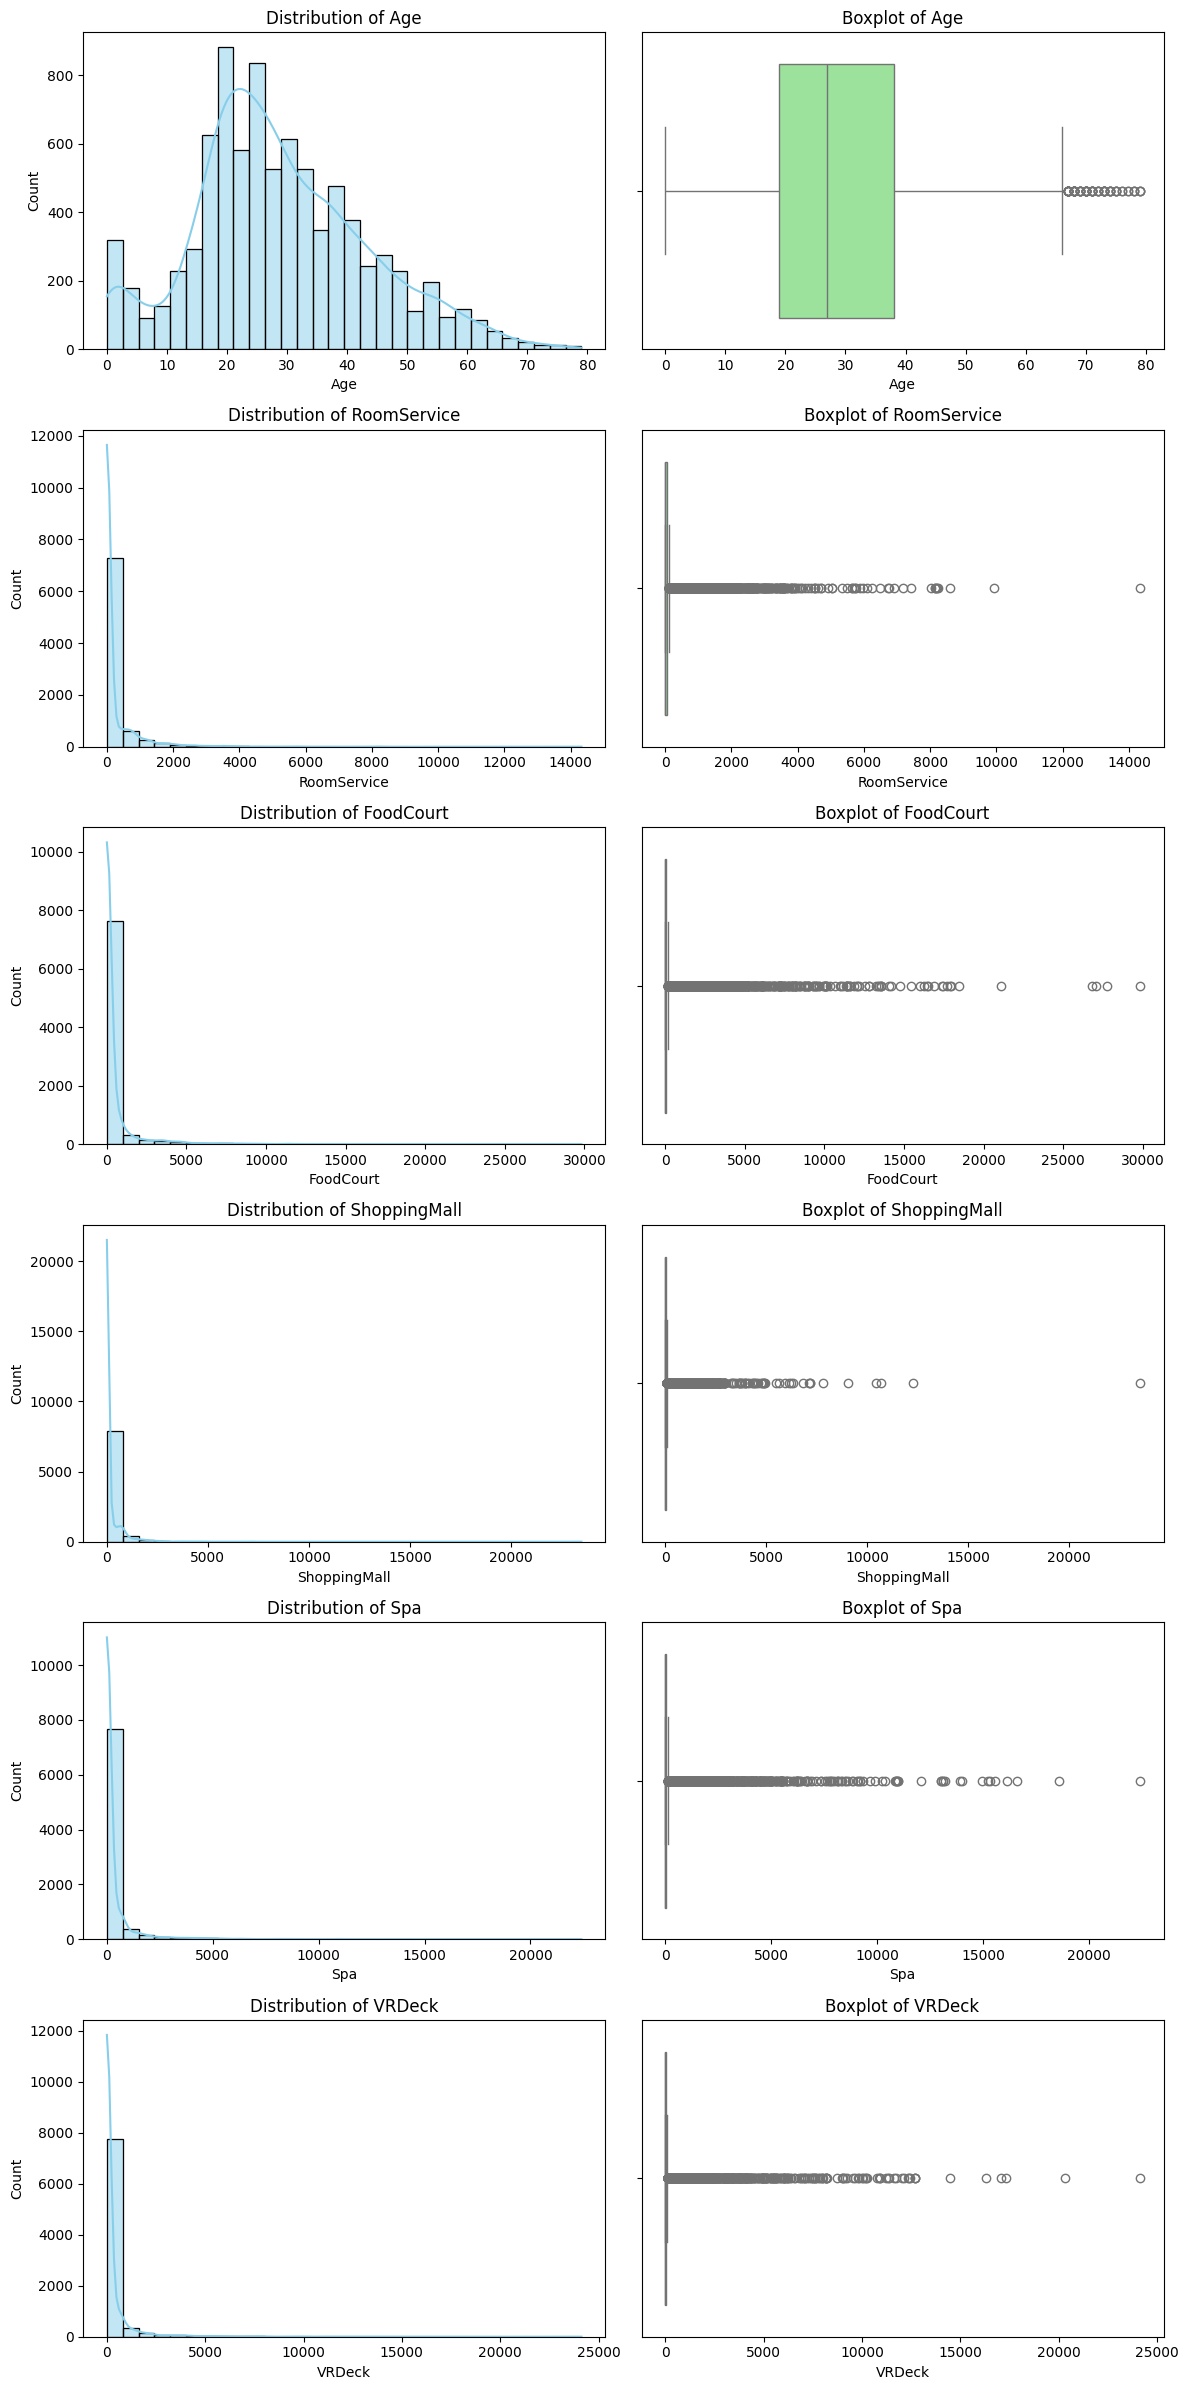

In [9]:
fig, axes = plt.subplots(len(num_features), 2, figsize=(12, 4*len(num_features)))
for i, feature in enumerate(num_features):
    # Histogram with KDE
    sns.histplot(df[feature].dropna(), kde=True, ax=axes[i, 0], bins=30, color="skyblue")
    axes[i, 0].set_title(f"Distribution of {feature}")
    
    # Boxplot
    sns.boxplot(x=df[feature], ax=axes[i, 1], color="lightgreen")
    axes[i, 1].set_title(f"Boxplot of {feature}")

plt.tight_layout()
plt.show()

> Age is relatively well-behaved (Minor skewness, manageable outliers. Standardization or normalization is enough.)  
> Spending features are problematic for linear models (Extreme skewness + outliers can reduce performance. Transformations (like log(1+x)) help compress the long tail and reveal structure.)  

#### What is the class balance of the target variable (Transported)?
(Imbalanced classes would influence model selection, evaluation metrics, and potential resampling needs.)

In [10]:
df['Transported'].value_counts()

Transported
True     4378
False    4315
Name: count, dtype: int64

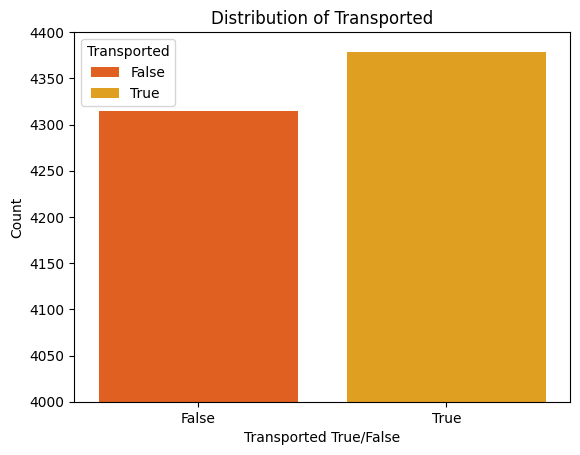

In [11]:
sns.countplot(x='Transported', data=df, palette='autumn', hue='Transported')
plt.title('Distribution of Transported')
plt.xlabel('Transported True/False')
plt.ylabel('Count')
plt.ylim(4000, 4400)
plt.show()

#### How does the transportation rate vary by HomePlanet, and what is the distribution of passengers across planets? 
(This establishes whether origin planet is a strong predictor.)

In [12]:
# Distribution of passengers
planet_counts = df['HomePlanet'].value_counts()

# Transportation rate per planet
transportation_rate = df.groupby('HomePlanet')['Transported'].mean() * 100

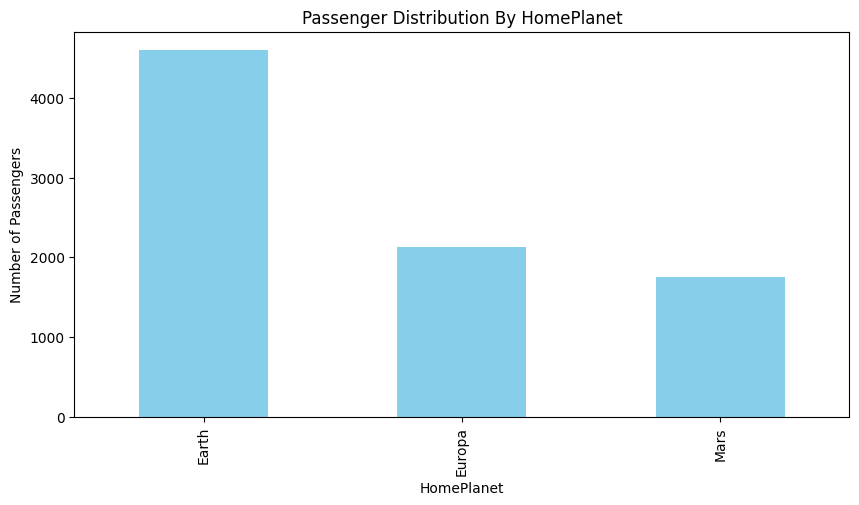

In [13]:
# Plot passenger distribution
plt.figure(figsize=(10, 5))
planet_counts.plot(kind='bar', color='skyblue')
plt.title('Passenger Distribution By HomePlanet')
plt.ylabel('Number of Passengers')
plt.show()

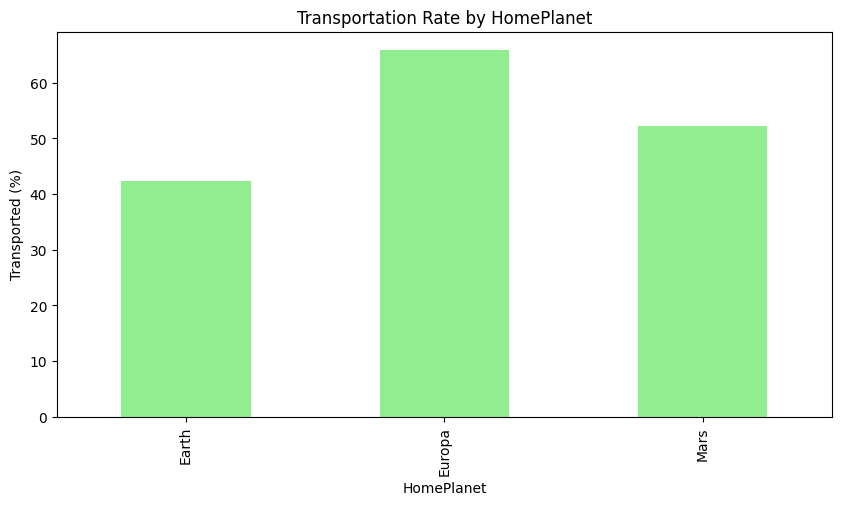

In [14]:
# Plot Transportation rate
plt.figure(figsize=(10, 5))
transportation_rate.plot(kind='bar', color='lightgreen')
plt.title("Transportation Rate by HomePlanet")
plt.ylabel("Transported (%)")
plt.show()

> Earth has the largest group but the lowest transport rate!  
Europa has fewer passengers but the highest transport rate!  
This imbalance means the model must learn both distribution and rate. otherwise it might bias toward Earth simply because of volume!  


> Europa passengers are much more likely to be transported, even though they’re fewer in number.  
The fact that Europa passengers have a much higher transport rate suggests strong correlation between origin and outcome.  

> Europa passengers are more likely to be transported (~66%) compared to Earth (~42%) and Mars (~52%)!

####  Does CryoSleep status significantly correlate with being transported?
Given that CryoSleep passengers are confined to cabins, this could be a dominant feature.

In [15]:
transportation_rate_by_cryosleep = df.groupby('CryoSleep')['Transported'].mean() * 100
transportation_rate_by_cryosleep

CryoSleep
False    32.892076
True     81.758314
Name: Transported, dtype: float64

> CryoSleep = False (awake passengers): Only about 33% were transported. → Being awake seems to reduce the likelihood of being transported.  
CryoSleep = True (asleep in suspended animation): About 82% were transported. → Passengers in CryoSleep were far more likely to be transported.  

> CryoSleep status is strongly correlated with Transported. The difference is huge (almost 50 percentage points)!  
> if CryoSleep is True, passengers are much more likely to be transported!

#### How does Destination affect transportation probability?
Different destinations may have different risk profiles.

In [16]:
# Count how many passengers are going to each destination.
dest_counts = df["Destination"].value_counts()
dest_counts

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

In [17]:
# Calculate the mean of Transported for each destination.
# Since Transported is True/False, the mean gives you the transportation probability (rate).
transportation_rate_by_dest = df.groupby('Destination')['Transported'].mean() * 100
transportation_rate_by_dest

Destination
55 Cancri e      61.000000
PSO J318.5-22    50.376884
TRAPPIST-1e      47.117498
Name: Transported, dtype: float64

**Passenger distribution**  
1. TRAPPIST‑1e: 5915 passengers (the majority group, ~5× larger than PSO J318.5‑22).   
2. 55 Cancri e: 1800 passengers.    
3. PSO J318.5‑22: 796 passengers (the smallest group).  
> **So** most of the dataset is dominated by TRAPPIST‑1e travelers.

**Transportation rates**
1. 55 Cancri e: ~61% transported (highest rate).  
2. PSO J318.5‑22: ~50% transported (about half).  
3. TRAPPIST‑1e: ~47% transported (lowest rate, despite being the largest group).  

> Passengers bound for "55 Cancri e" are much more likely to be transported compared to "TRAPPIST‑1e".  
> "TRAPPIST‑1e" dominates in passenger count but has the lowest transport rate.  
(If we train a model without care, it may bias toward "TRAPPIST‑1e" patterns simply because of volume.  
Balancing or weighting may be needed to ensure smaller groups (like PSO J318.5‑22) aren’t ignored.)

#### Does VIP status influence the likelihood of being transported?  
Tests whether premium service provides any "protection" or risk.

In [18]:
transportation_rate_by_VIP = df.groupby('VIP')['Transported'].mean() * 100
transportation_rate_by_VIP

VIP
False    50.633217
True     38.190955
Name: Transported, dtype: float64

In [19]:
df['VIP'].value_counts()

VIP
False    8291
True      199
Name: count, dtype: int64

**Passenger distribution**  
1. Non‑VIP: 8291 passengers (the overwhelming majority).
2. VIP: 199 passengers (tiny minority, ~2.3% of the dataset).
3. So the dataset is heavily imbalanced — most passengers are not VIPs.

**Transportation rates**  
1. Non‑VIP: ~50.6% transported.
2. VIP: ~38.2% transported.
3. This means VIP passengers were less likely to be transported compared to non‑VIPs.

> Being VIP actually correlates with a lower chance of being transported.  
VIP passengers may have had different cabin assignments or behaviors that reduced their transport likelihood.  
Yes, VIP status influences transport likelihood — VIPs were less likely to be transported (~38% vs ~51%).    
However, the VIP group is very small, so the effect should be interpreted with caution!  

#### Can we extract meaningful signals from the Cabin feature (deck, cabin number, port vs. starboard side)?
The deck, position on ship, and side could all carry spatial information about transport likelihood.

In [20]:
df[['Deck', 'CabinNum', 'Side']] = df['Cabin'].str.split("/", expand=True)  
df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce')

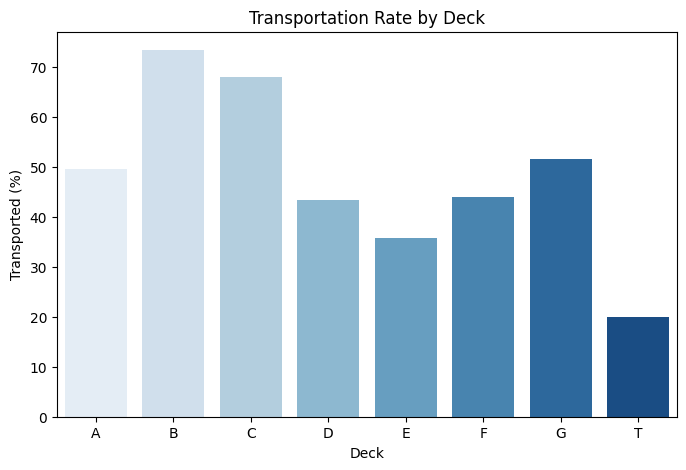

In [21]:
# --- Transport rate by Deck ---
transport_rate_deck = df.groupby('Deck')['Transported'].mean() * 100
plt.figure(figsize=(8,5))
sns.barplot(x=transport_rate_deck.index, y=transport_rate_deck.values, hue=transport_rate_deck.index,  palette="Blues")
plt.title("Transportation Rate by Deck")
plt.ylabel("Transported (%)")
plt.show()

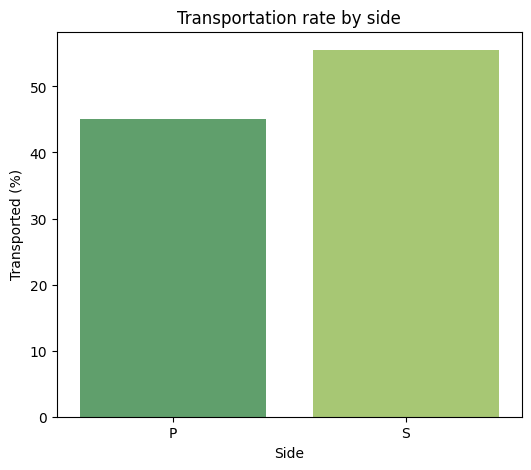

In [22]:
# --- Transport rate by Side --
transport_rate_side = df.groupby('Side')['Transported'].mean() * 100
plt.figure(figsize=(6, 5))
sns.barplot(x=transport_rate_side.index, y=transport_rate_side.values, hue=transport_rate_side.index, palette='summer')
plt.title("Transportation rate by side")
plt.ylabel("Transported (%)")
plt.show()

In [23]:
# --- Transport rate by CabinNum --- #
# We create bins to reduce noise and see broader patterns.
df['CabinNum_bin'] = pd.cut(df['CabinNum'], bins=20)  # divide into 20 bins

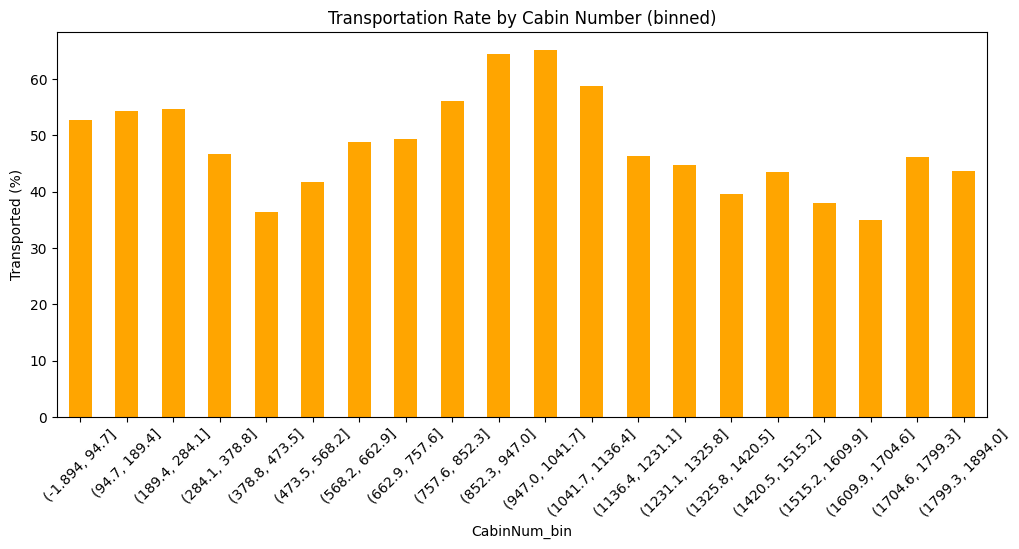

In [24]:
transport_rate_num = df.groupby('CabinNum_bin', observed=True)['Transported'].mean() * 100
plt.figure(figsize=(12,5))
transport_rate_num.plot(kind='bar', color="orange")
plt.title("Transportation Rate by Cabin Number (binned)")
plt.ylabel("Transported (%)")
plt.xticks(rotation=45)
plt.show()

1. Deck B (72%) and Deck C (67%) → highest transport rates.
2. Deck T (15%) → extremely low transport rate, stands out as an anomaly.
3. Other decks (A, G, F, D, E) hover between ~33–50%.
4. Deck location is strongly predictive.
5. Certain decks (B, C) were much more likely to be transported, while Deck T was almost excluded.
6. This suggests spatial clustering — where you were located on the ship mattered a lot.
7. Deck is the strongest predictor (clear differences in transport rates).
8. Side adds moderate predictive value.
9. CabinNum shows localized fluctuations, so binning or interactions may help.

#### Does the group structure in PassengerId (traveling alone vs. in groups, group size) correlate with transportation?
Family/group dynamics might affect outcomes.

In [25]:
# 1. PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. 
# People in a group are often family members, but not always
df[['passenger_group', 'passenger_number_in_group']] = df['PassengerId'].str.split('_', expand=True)
df['passenger_group'] = df['passenger_group'].astype(int)
df['passenger_number_in_group'] = df['passenger_number_in_group'].astype(int)

In [26]:
# group size
group_sizes = df.groupby('passenger_group').size().reset_index(name='group_size')
df = df.merge(group_sizes, on='passenger_group', how='left')

In [27]:
# Group transport rate
group_transport_rate = df.groupby('passenger_group')['Transported'].mean().reset_index(name='group_transport_rate')
df = df.merge(group_transport_rate, on='passenger_group', how='left')

In [28]:
group_consistency = df.groupby('passenger_group')['Transported'].nunique().reset_index(name='group_consistency')
df = df.merge(group_consistency, on='passenger_group', how='left')

Text(0.5, 1.0, 'Distribution of Group Transport Rates')

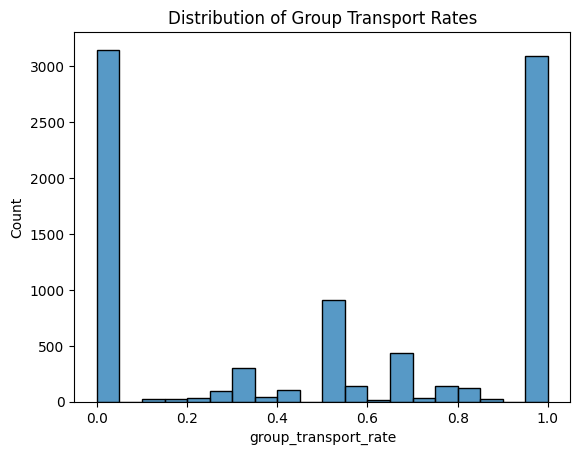

In [29]:
# Distribution of group transport rates
sns.histplot(df['group_transport_rate'], bins=20)
plt.title("Distribution of Group Transport Rates")

Text(0.5, 1.0, 'Transport Probability by Group Size')

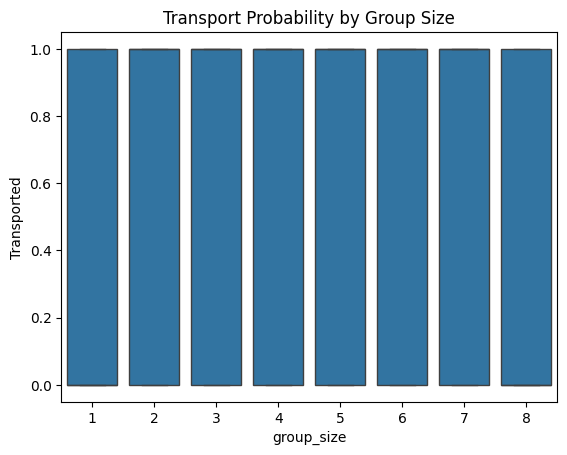

In [30]:
# Transport probability vs group size
sns.boxplot(x='group_size', y='Transported', data=df)
plt.title("Transport Probability by Group Size")

#### Solo vs. group travelers: Do solo passengers have different transport rates than those in groups?

In [31]:
group_size_transportation_rate = df.groupby('group_size')['Transported'].mean().reset_index()

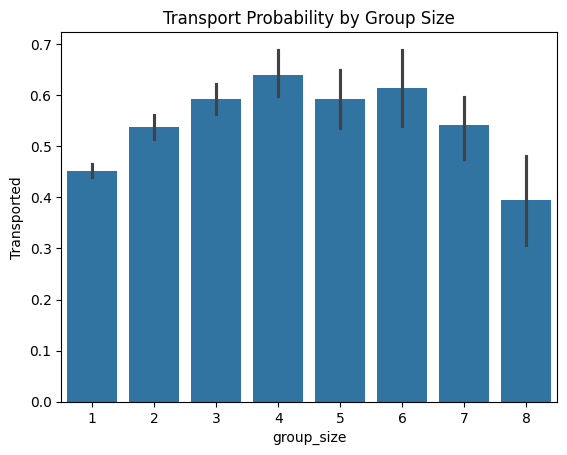

In [32]:
sns.barplot(x='group_size', y='Transported', data=df, estimator='mean')
plt.title("Transport Probability by Group Size")
plt.show()

Text(0.5, 1.0, 'Transport Probability by Group Size')

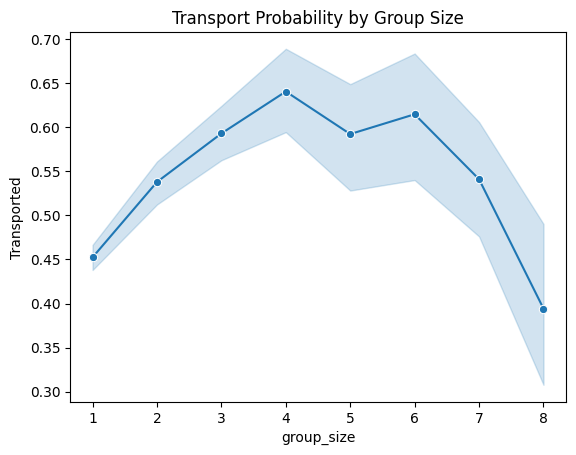

In [33]:
sns.lineplot(x='group_size', y='Transported', data=df, estimator='mean', marker='o')
plt.title("Transport Probability by Group Size")

**Interpretation**  
1. Solo travelers (group size = 1): Transport rate ≈ 0.45 → slightly below average.
2. Small groups (2–3): Around 0.52–0.55 → modestly higher than solos.
3. Medium groups (4–6): Highest transport rates (0.55–0.63), especially group size 4 (≈0.63) and 6 (≈0.60).
4. Large groups (7–8): Rates drop again (≈0.40–0.50), with group size 8 being the lowest.
5. Solo passengers seem less likely to be transported compared to those in small/medium groups.
6. Medium-sized groups (4–6) have the strongest chance of being transported together
7. Large groups (7–8) may be more heterogeneous (mixed outcomes), which lowers the average transport rate.

#### Is there a relationship between total spending (sum of all amenities) and being transported?
Could reveal whether activity level or wealth proxies affect outcomes.

In [34]:
df['total_spent'] = df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)

<Axes: xlabel='total_spent', ylabel='Density'>

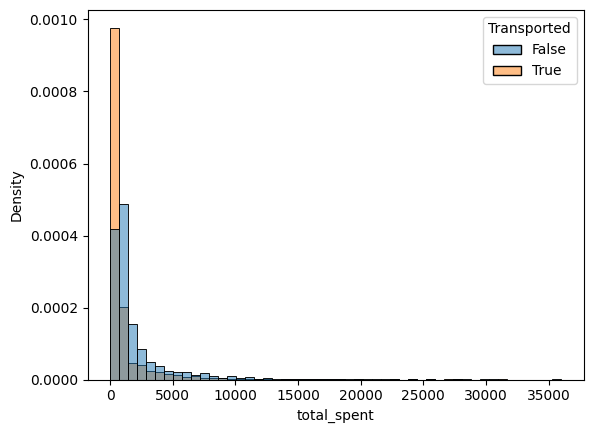

In [35]:
sns.histplot(data=df, x='total_spent', hue='Transported', bins=50, stat='density', common_norm=False)

In [36]:
# Step 2: Create bins (quartiles here, but you can adjust)
df['spend_category'] = pd.qcut(
    df['total_spent'], 
    q=4, 
    labels=['low','medium','high'], 
    duplicates='drop'
)

# Step 3: Calculate transport probability per category
spend_rates = df.groupby('spend_category')['Transported'].mean().reset_index()

C:\Users\Farhad\AppData\Local\Temp\ipykernel_10944\2992477759.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spend_rates = df.groupby('spend_category')['Transported'].mean().reset_index()


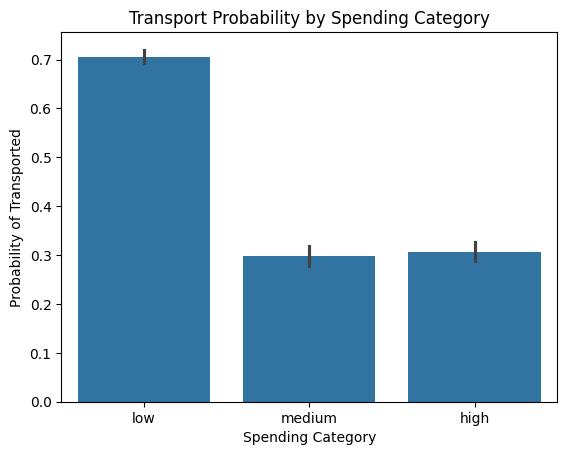

In [37]:
sns.barplot(x='spend_category', y='Transported', data=df, estimator='mean')
plt.title("Transport Probability by Spending Category")
plt.ylabel("Probability of Transported")
plt.xlabel("Spending Category")
plt.show()

> Passengers who spent nothing are much more likely to be transported. This makes sense because CryoSleep passengers almost always have zero spending (they don’t use amenities)  
Passengers who actively used amenities are much less likely to be transported. This suggests that being awake and active on the ship reduced the chance of transport! 
1. Zero spending ≈ CryoSleep → high transport probability.
2. Non-zero spending ≈ Awake → lower transport probability.

> Warning for multicollinearity between 'total_spent' and 'CryoSleep'!

####  Are passengers in CryoSleep showing zero spending across all amenities, and does this create multicollinearity?
This logical constraint could affect feature engineering and model interpretation.

In [38]:
# 3. CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
# Check if CryoSleep passengers spent anything
cryo_spending = df.loc[df['CryoSleep'] == True, ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)

# Count how many CryoSleep passengers have non-zero spending
nonzero_cryo = (cryo_spending > 0).sum()
total_cryo = cryo_spending.shape[0]
print(f"Total CryoSleep passengers: {total_cryo}")
print(f"CryoSleep passengers with non-zero spending: {nonzero_cryo}")

Total CryoSleep passengers: 3037
CryoSleep passengers with non-zero spending: 0


In [39]:
# Correlation between CryoSleep and total_spent
df['CryoSleep_binary'] = df['CryoSleep'].dropna().astype(int)  # convert True/False to 1/0
corr = df[['CryoSleep_binary','total_spent']].corr()
print(corr)

                  CryoSleep_binary  total_spent
CryoSleep_binary          1.000000    -0.383115
total_spent              -0.383115     1.000000


#### How do Age and spending patterns interact—do younger/older passengers spend differently, and does this relate to transportation?
Age-spending interactions might be predictive.

In [41]:
df['age_bin'] = pd.cut(
    df['Age'],
    bins=[-1, 12, 18, 30, 50, 80],
    labels=['child', 'teen', 'young_adult', 'adult', 'senior']
)

In [43]:
df.groupby('age_bin')['total_spent'].mean()

C:\Users\Farhad\AppData\Local\Temp\ipykernel_10944\1511419835.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('age_bin')['total_spent'].mean()


age_bin
child             0.000000
teen            912.220963
young_adult    1404.752934
adult          2010.292820
senior         1903.819539
Name: total_spent, dtype: float64

Text(0.5, 1.0, 'Spending Patterns by Age Group')

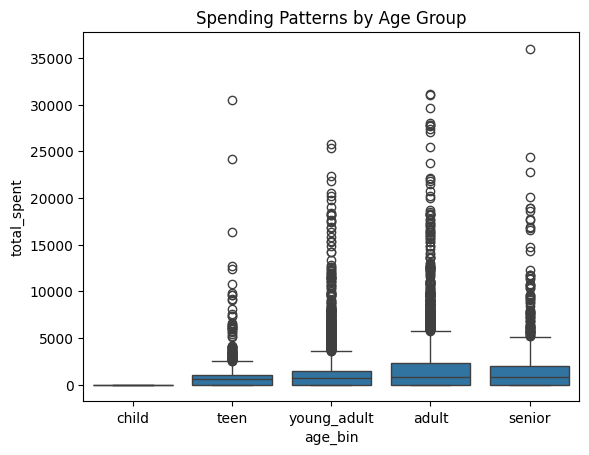

In [44]:
sns.boxplot(x='age_bin', y='total_spent', data=df)
plt.title("Spending Patterns by Age Group")

In [45]:
df.groupby('age_bin')['Transported'].mean()

C:\Users\Farhad\AppData\Local\Temp\ipykernel_10944\737478203.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('age_bin')['Transported'].mean()


age_bin
child          0.699752
teen           0.537299
young_adult    0.468190
adult          0.479432
senior         0.484396
Name: Transported, dtype: float64

In [46]:
pd.crosstab(df['age_bin'], df['CryoSleep'], values=df['Transported'], aggfunc='mean')

CryoSleep,False,True
age_bin,,
child,0.682266,0.724138
teen,0.280072,0.836170
young_adult,0.309623,0.812127
adult,0.297205,0.846690
senior,0.300420,0.858921


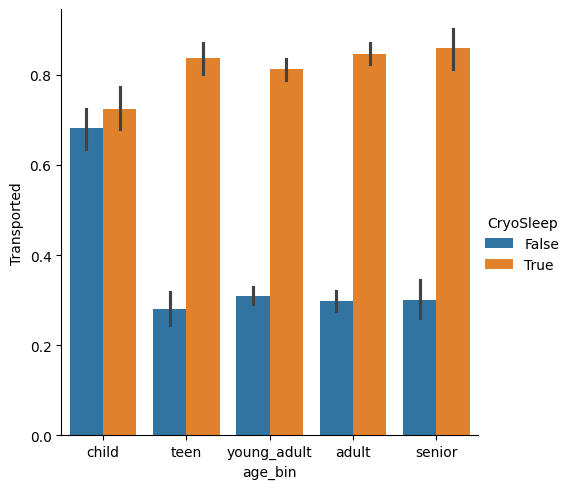

In [47]:
sns.catplot(x='age_bin', y='Transported', hue='CryoSleep', data=df, kind='bar', estimator='mean')

1. CryoSleep = True: Transport probability is very high across all age bins (≈0.81–0.86). → Being in CryoSleep is the dominant factor, regardless of age.
2. CryoSleep = False: Transport probability is much lower (≈0.28–0.68). → Awake passengers are less likely to be transported, but there’s variation:  
        1. Children (0.68): Even awake children have a relatively high transport rate compared to teens/adults.  
        2. Teens, young adults, adults, seniors (≈0.28–0.30): All much lower.  
3. Children are an exception: even awake, they have a higher transport rate (~0.68).
4. For older groups, awake passengers are consistently low (~0.28–0.30). → Age matters mostly when CryoSleep = False.
5. CryoSleep and Age interact.
6. Age modifies transport probability only when CryoSleep = False.
7. This is an interaction effect, not multicollinearity.

#### What correlations exist among the five amenity spending features?
High multicollinearity might suggest combining features or using regularization.

In [48]:
spending_features = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
corr_matrix = df[spending_features].corr()

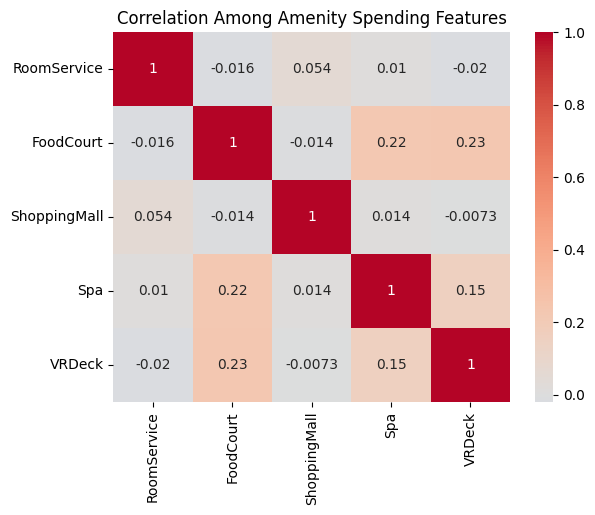

In [49]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Among Amenity Spending Features")
plt.show()

> The five amenity spending features (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck) are not strongly correlated with each other.  
The highest correlations you found (≈0.22–0.23) are weak. This means passengers’ spending patterns are independent across amenities — someone who spends in the Spa doesn’t necessarily spend in the FoodCourt or VRDeck.

#### Are there clear linear separations in any feature with respect to the target, or do relationships appear non-linear?
Linear patterns favor logistic regression; complex boundaries suggest tree-based or ensemble methods.

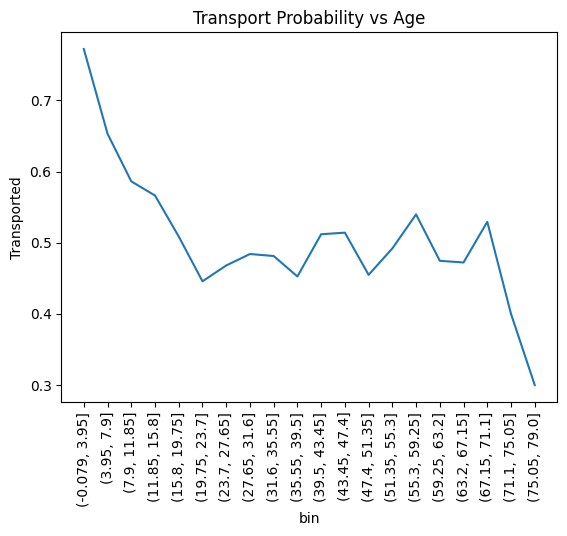

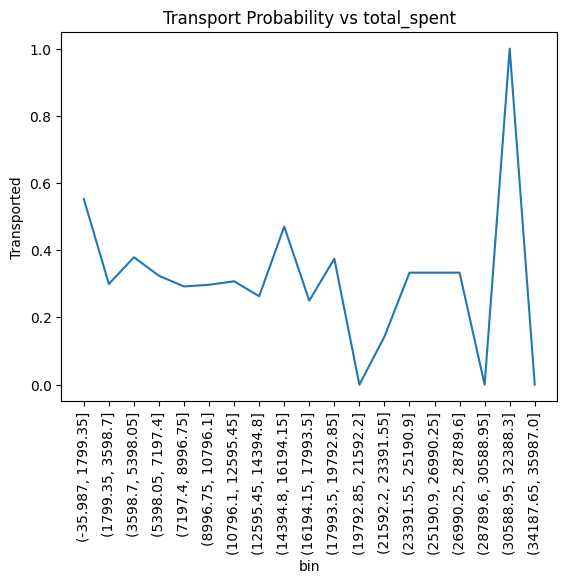

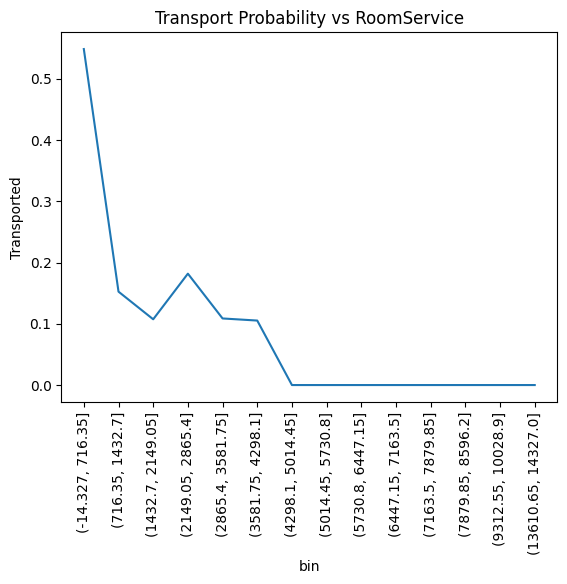

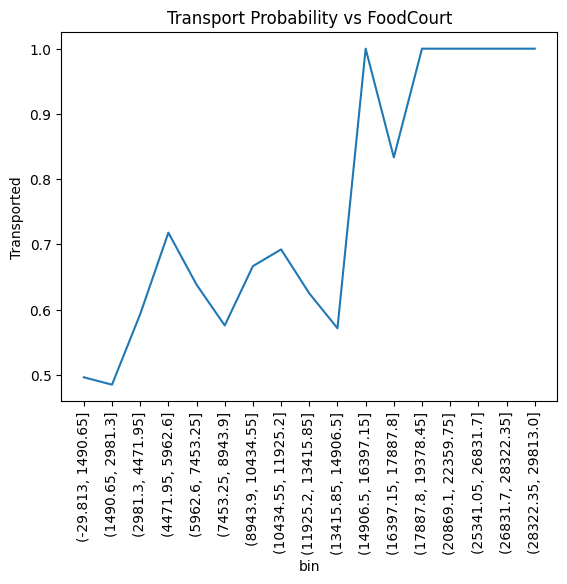

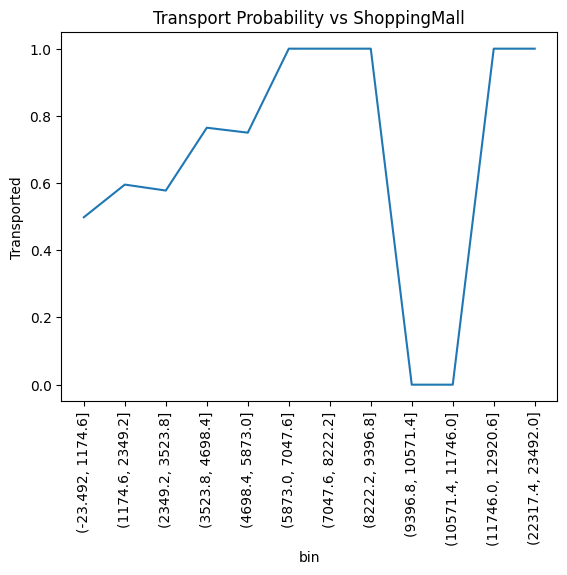

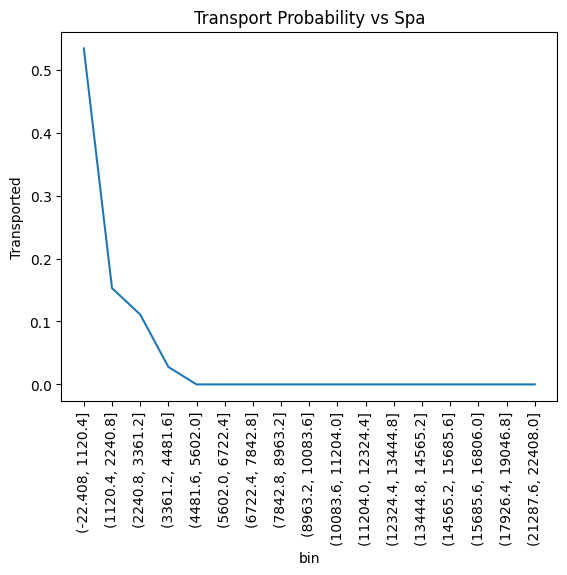

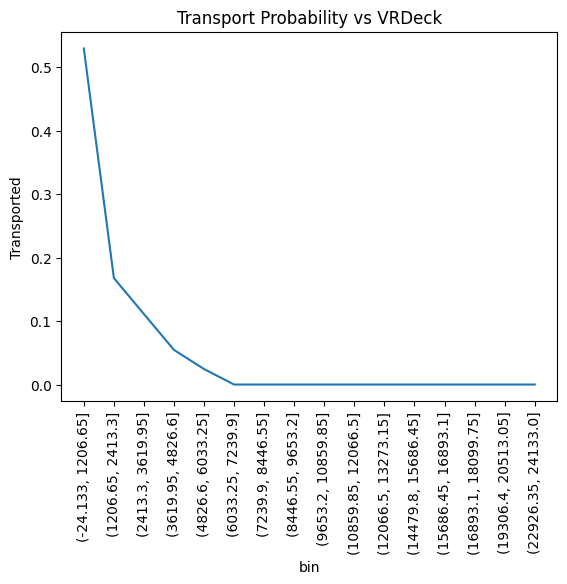

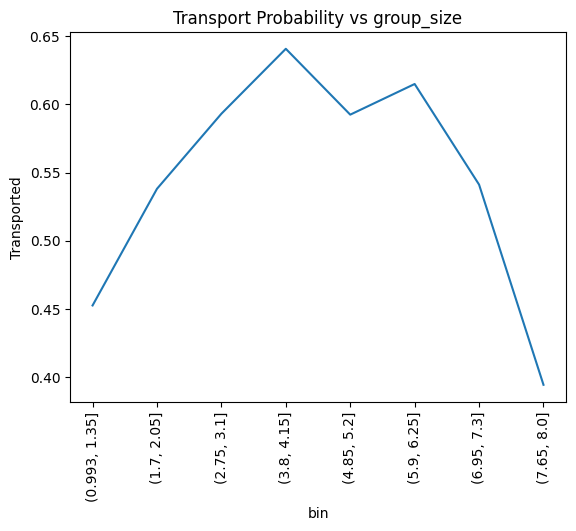

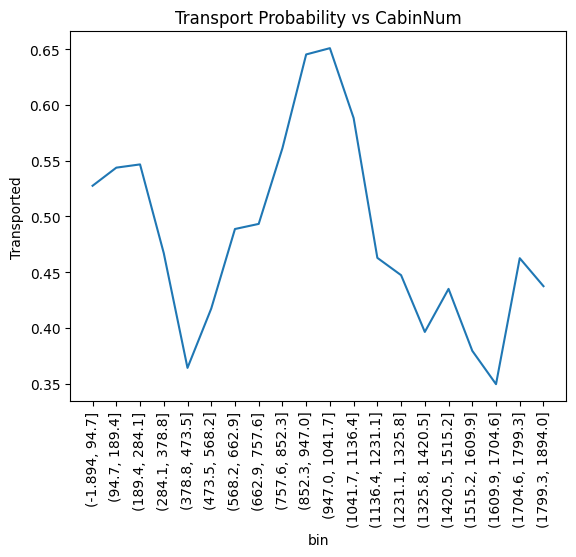

In [63]:
# Define your numerical features
num_features = [
    'Age', 'total_spent', 'RoomService', 'FoodCourt',
    'ShoppingMall', 'Spa', 'VRDeck', 'group_size', 'CabinNum'
]

def plot_continuous_relationship(df, feature, bins=20):
    # Bin the feature into intervals
    df['bin'] = pd.cut(df[feature], bins=bins)
    
    # Calculate mean transport probability per bin
    rates = df.groupby('bin', observed=True)['Transported'].mean().reset_index()
    
    # Plot the curve
    sns.lineplot(x=rates['bin'].astype(str), y=rates['Transported'])
    plt.xticks(rotation=90)
    plt.title(f"Transport Probability vs {feature}")
    plt.show()

# Loop through all numerical features
for feature in num_features:
    plot_continuous_relationship(df, feature, bins=20)

> The numerical features do not show linear separations with respect to the target. Instead, they exhibit non-linear patterns (mountain-shaped, elbow-shaped, step-like). This indicates that logistic regression without transformations would struggle to capture the relationships.

In [64]:
df.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,passenger_group,passenger_number_in_group,group_size,group_transport_rate,group_consistency,total_spent,spend_category,CryoSleep_binary,age_bin,bin
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,1,1,1,0.0,1,0.0,low,0.0,adult,"(-1.894, 94.7]"
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,2,1,1,1.0,1,736.0,medium,0.0,young_adult,"(-1.894, 94.7]"
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,3,1,2,0.0,1,10383.0,high,0.0,senior,"(-1.894, 94.7]"
